In [76]:
import time
import datetime
import sklearn
import pandas as pd
import numpy as np
from sklearn.cross_validation import KFold, cross_val_score
from sklearn.grid_search import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
pd.set_option('display.max_columns', 500)
from sklearn.cross_validation import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline
from joblib import Parallel, delayed

In [118]:
# get data
dt_path = 'dt.pickle'
dt = pd.read_pickle(dt_path)

# add some logs of features to the matrix 
dt['log_Views'] = np.log(dt['Views']+1)
dt['log_Car_age'] = np.log(dt['Car_age']+1)
dt['log_Warranty_end'] = np.log(dt['Warranty_end'] + 1)
dt['log_Engine_capacity'] = np.log(dt['Engine_capacity'])
dt['log_Engine_hp'] = np.log(dt['Engine_hp'])
dt['log_run_km'] = np.log(dt['run_km']+1)

y = np.log(dt['Price_rub'])
X = dt
del X['Price_rub'], X['ID'], X['Parsing date']

In [119]:
# one hot encoding
X = pd.get_dummies(X)

#split data to train and test
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2, random_state=777, stratify = dt['CarName'])

def MAPE(y_true, y_pred):
    mape = np.sum(np.abs((y_true - y_pred) / y_true) / len(y_true))
    return mape

In [120]:
# run grid search for optimal number of trees

gb_result = pd.DataFrame(columns = {'number_of_trees','metric','learning_time'})

metric_list = []
elapsed_time_list = []
    
for num_trees in [100,500,1000,1750,2000,2250,2500,3000]:

    clf = GradientBoostingRegressor(n_estimators=num_trees)

    start_time = datetime.datetime.now()
    clf.fit(X_train, y_train)
    elapsed_time = datetime.datetime.now() - start_time

    predictions = clf.predict(X_test)
    metric = MAPE(np.exp(y_test), np.exp(predictions))
    metric_list.append(metric)
    
    gb_result = pd.concat([gb_result, pd.DataFrame({'number_of_trees' : [num_trees], 
                                                    'metric' : [np.mean(metric_list)], 
                                                    'learning_time':[elapsed_time]})])
    print(num_trees)

100
500
1000
1750
2000
2250
2500
3000


In [121]:
gb_result

,learning_time,metric,number_of_trees
0,00:00:06.665436,0.112597,100.0
0,00:00:25.866338,0.102247,500.0
0,00:00:49.434382,0.097744,1000.0
0,00:01:28.022389,0.095219,1750.0
0,00:01:41.723765,0.093683,2000.0
0,00:01:54.867320,0.092658,2250.0
0,00:02:07.079947,0.091952,2500.0
0,00:02:34.571915,0.091415,3000.0


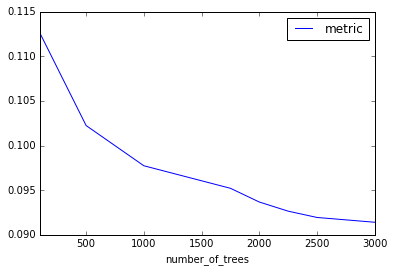

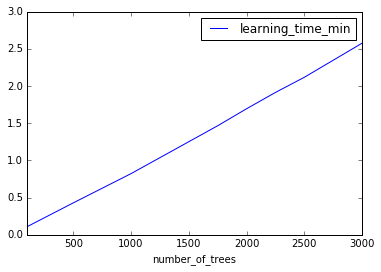

In [122]:
#plot results
gb_result.plot('number_of_trees','metric')
gb_result['learning_time_min'] = gb_result['learning_time'] / np.timedelta64(1,'m')
gb_result.plot('number_of_trees','learning_time_min')